# Desafío 5: BERT Sentiment Analysis

## Obtención del dataset + EDA

In [27]:
import os

if not (os.access('apps.csv', os.F_OK) and os.access('reviews.csv', os.F_OK)):
    !curl -L -o 'apps.csv' 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
    !curl -L -o 'reviews.csv' 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [28]:
import pandas as pd

df = pd.read_csv('reviews.csv')
df.head()

userName                                          userImage  \
0     Andrew Thomas  https://lh3.googleusercontent.com/a-/AOh14GiHd...   
1      Craig Haines  https://lh3.googleusercontent.com/-hoe0kwSJgPQ...   
2     steven adkins  https://lh3.googleusercontent.com/a-/AOh14GiXw...   
3  Lars Panzerbjørn  https://lh3.googleusercontent.com/a-/AOh14Gg-h...   
4     Scott Prewitt  https://lh3.googleusercontent.com/-K-X1-YsVd6U...   

                                             content  score  thumbsUpCount  \
0  Update: After getting a response from the deve...      1             21   
1  Used it for a fair amount of time without any ...      1             11   
2  Your app sucks now!!!!! Used to be good but no...      1             17   
3  It seems OK, but very basic. Recurring tasks n...      1            192   
4  Absolutely worthless. This app runs a prohibit...      1             42   

  reviewCreatedVersion                   at  \
0             4.17.0.3  2020-04-05 22:25:57   
1             4.17.0.3  2020-04-04 13:40:01   
2             4.17.0.3  2020-04-01 16:18:13   
3             4.17.0.2  2020-03-12 08:17:34   
4             4.17.0.2  2020-03-14 17:41:01   

                                        replyContent            repliedAt  \
0  According to our TOS, and the term you have ag...  2020-04-05 15:10:24   
1  It sounds like you logged in with a different ...  2020-04-05 15:11:35   
2  This sounds odd! We are not aware of any issue...  2020-04-02 16:05:56   
3  We do offer this option as part of the Advance...  2020-03-15 06:20:13   
4  We're sorry you feel this way! 90% of the app ...  2020-03-15 23:45:51   

       sortOrder      appId  
0  most_relevant  com.anydo  
1  most_relevant  com.anydo  
2  most_relevant  com.anydo  
3  most_relevant  com.anydo  
4  most_relevant  com.anydo

In [3]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


Se chequea el balance de los targets.

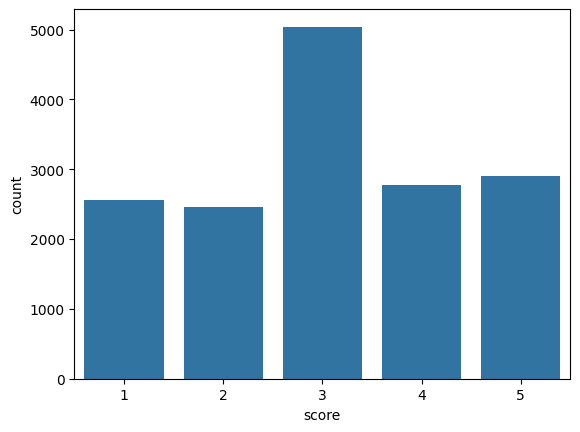

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df.score)
plt.show()

Se chequea la dimensionalidad de las críticas.

In [5]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Se chequea la distribución de la longitud de las críticas.

Median: 139.0


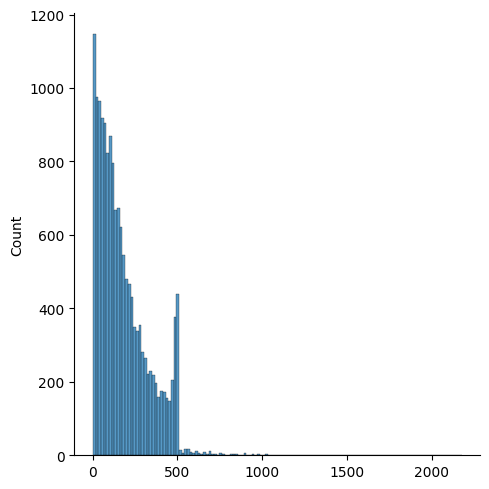

In [6]:
import numpy as np

sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)
plt.show()

## Construcción de la función Data Generator

In [15]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer

In [17]:
# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [12]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [13]:
print(idx_train.shape[0], idx_val.shape[0], idx_test.shape[0])

10076 2520 3150


In [14]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i], 
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]
  
    return train_InputExamples, validation_InputExamples

 
def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

## Modelo #1

### Definición

Este modelo hará _feature extraction_ (**no** se entrenarán los pesos pre-entrenados de `BERT`), tendrá una única capa densa y se acomodará el dataset para tener 3 targets.

In [5]:
import tensorflow
from transformers import TFBertModel

In [7]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [8]:
max_length = 140
output_shape = 3

In [22]:
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_1 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

In [23]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

Se define una función para graficar los resultados del entrenamiento.

In [19]:
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()

### Feature Engineering

Se modifican los datos para tener 3 salidas.

In [29]:
df['sentiment'] = df.score.apply(lambda x: 0 if x <= 2 else 1 if x == 3 else 2)

class_names = ['negative', 'neutral', 'positive']

Se chequea el balance de los nuevos targets.

In [21]:
ax = sns.countplot(df, x='sentiment')
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)
plt.show()

/tmp/ipykernel_26895/2622544771.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


Se observa que en este caso las clases están balanceadas.

A continuación se transforman los targets a variables **OHE**.

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
y_1 = df['sentiment'].values
print("y shape:", y_1.shape)
y_1 = to_categorical(y_1)
print(y_1[:3])
output_shape = y_1.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
output shape: 3


### Data Generator


In [24]:
train_InputExamples_1, validation_InputExamples_1 = convert_data_to_examples(sentences, y_1, idx_train, idx_val)

train_data_1 = convert_examples_to_tf_dataset(list(train_InputExamples_1), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data_1 = train_data_1.shuffle(100).batch(32)

validation_data_1 = convert_examples_to_tf_dataset(list(validation_InputExamples_1), bert_tokenizer, max_length=max_length)
validation_data_1 = validation_data_1.batch(32)

In [25]:
pred_sentences_1 = [sentences[i] for i in idx_test]
tf_batch_1 = bert_tokenizer(pred_sentences_1, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [26]:
X_test_1 = [tf_batch_1['input_ids'],  
          tf_batch_1['attention_mask']]

In [27]:
y_test_1 = y_1[idx_test]

### Entrenamiento

In [29]:
history1 = model_1.fit(train_data_1, epochs=5, validation_data=validation_data_1)

Epoch 1/5


I0000 00:00:1723929782.301496     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 137s 277ms/step - loss: 1.1066 - accuracy: 0.3991 - f1_score: 0.3942 - val_loss: 1.0112 - val_accuracy: 0.4996 - val_f1_score: 0.4153
Epoch 2/5
315/315 [==============================] - 74s 236ms/step - loss: 1.0317 - accuracy: 0.4718 - f1_score: 0.4626 - val_loss: 0.9564 - val_accuracy: 0.5389 - val_f1_score: 0.4949
Epoch 3/5
315/315 [==============================] - 74s 236ms/step - loss: 0.9895 - accuracy: 0.5043 - f1_score: 0.4937 - val_loss: 0.9286 - val_accuracy: 0.5548 - val_f1_score: 0.5468
Epoch 4/5
315/315 [==============================] - 74s 236ms/step - loss: 0.9751 - accuracy: 0.5156 - f1_score: 0.5059 - val_loss: 0.9160 - val_accuracy: 0.5516 - val_f1_score: 0.5123
Epoch 5/5
315/315 [==============================] - 74s 236ms/step - loss: 0.9683 - accuracy: 0.5236 - f1_score: 0.5124 - val_loss: 0.9385 - val_accuracy: 0.5413 - val_f1_score: 0.4585


In [30]:
plot_train_metrics(history1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

### Evaluación

In [32]:
y_hat_prob_1 = model_1.predict(X_test_1)
y_hat_prob_1[:3]

99/99 [==============================] - 29s 175ms/step


array([[0.5053864 , 0.25379986, 0.24081375],
       [0.41951004, 0.22005934, 0.36043063],
       [0.18717633, 0.2705913 , 0.5422324 ]], dtype=float32)

In [33]:
y_hat_1 = np.argmax(y_hat_prob_1, axis=1)

In [34]:
# Calcular la exactitud (accuracy)
scores_1 = model_1.evaluate(X_test_1, y_test_1)
scores_1[1]

99/99 [==============================] - 29s 178ms/step - loss: 0.9315 - accuracy: 0.5527 - f1_score: 0.4688


0.5526984333992004

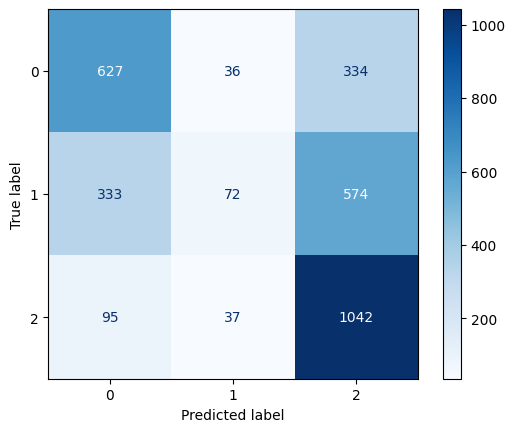

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_1 = confusion_matrix(y_test_1.argmax(axis=1), y_hat_1)
cmd_1 = ConfusionMatrixDisplay(cm_1, display_labels=list(range(3)))
cmd_1.plot(cmap=plt.cm.Blues)
plt.show()

### Comentarios

Se observa un desempeño apenas mejor que un caso trivial.

## Modelo #2

### Definición

Este modelo es igual al anterior, pero se hará _fine tunning_, es decir, se entrenarán los pesos de la arquitectura `BERT`.

In [28]:
model_2 = model_1

# Colocar todas las layers como entrenables
for layer in model_2.layers:
  layer.trainable = True

# Como es fine tunning se recomiendo utiliza al menos un learning rate 100 veces
# menor
model_2.compile(optimizer=tensorflow.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

In [29]:
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

### Entrenamiento

In [30]:
history2 = model_2.fit(train_data_1, epochs=5, validation_data=validation_data_1)

Epoch 1/5


I0000 00:00:1723959697.600072     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 394s 980ms/step - loss: 0.8509 - accuracy: 0.5848 - f1_score: 0.4832 - val_loss: 0.7054 - val_accuracy: 0.6833 - val_f1_score: 0.5836
Epoch 2/5
315/315 [==============================] - 296s 939ms/step - loss: 0.6574 - accuracy: 0.7090 - f1_score: 0.6192 - val_loss: 0.6397 - val_accuracy: 0.7242 - val_f1_score: 0.6462
Epoch 3/5
315/315 [==============================] - 295s 937ms/step - loss: 0.5317 - accuracy: 0.7774 - f1_score: 0.6683 - val_loss: 0.6621 - val_accuracy: 0.7421 - val_f1_score: 0.6874
Epoch 4/5
315/315 [==============================] - 295s 937ms/step - loss: 0.3956 - accuracy: 0.8428 - f1_score: 0.7057 - val_loss: 0.6807 - val_accuracy: 0.7694 - val_f1_score: 0.7223
Epoch 5/5
315/315 [==============================] - 295s 937ms/step - loss: 0.2737 - accuracy: 0.8978 - f1_score: 0.7385 - val_loss: 0.6796 - val_accuracy: 0.7952 - val_f1_score: 0.7533


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

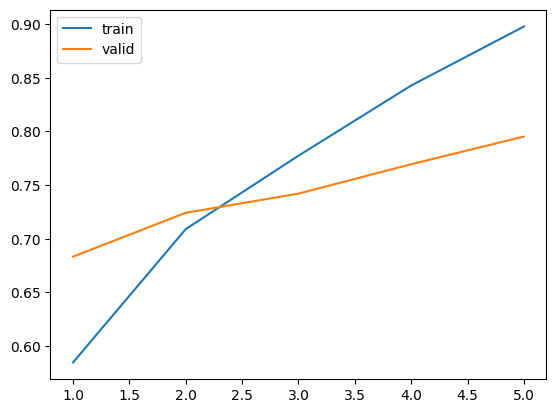

In [31]:
plot_train_metrics(history2)

### Evaluación

In [32]:
y_hat_prob_2 = model_2.predict(X_test_1)
y_hat_prob_2[:3]

99/99 [==============================] - 44s 312ms/step


array([[0.12406698, 0.32139462, 0.5545384 ],
       [0.86577773, 0.12717173, 0.00705052],
       [0.0192071 , 0.25307682, 0.72771615]], dtype=float32)

In [34]:
y_hat_2 = np.argmax(y_hat_prob_2, axis=1)

In [35]:
# Calcular la exactitud (accuracy)
scores_2 = model_2.evaluate(X_test_1, y_test_1)
scores_2[1]

99/99 [==============================] - 43s 308ms/step - loss: 0.6147 - accuracy: 0.8152 - f1_score: 0.7556


0.8152381181716919

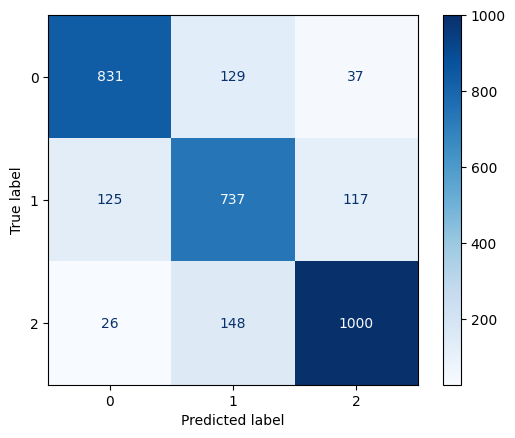

In [38]:
cm_2 = confusion_matrix(y_test_1.argmax(axis=1), y_hat_2)
cmd_2 = ConfusionMatrixDisplay(cm_2, display_labels=list(range(3)))
cmd_2.plot(cmap=plt.cm.Blues)
plt.show()

### Comentarios

En este caso se observa un mucho mejor desempeño, obteniéndose un buen clasificador de textos, considerando que tan solo se ha entrenado durante 5 épocas.

## Modelo #3

### Definición

Este modelo también hará _fine tunning_, pero contará con 2 capas densas adicionales previas a la salida.

In [12]:
bert_model.bert.trainable = True

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
x = tensorflow.keras.layers.Dense(12, activation='relu')(x)
x = tensorflow.keras.layers.Dense(6, activation='relu')(x)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_3 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                       

### Entrenamiento

In [24]:
history3 = model_3.fit(train_data_1, epochs=5, validation_data=validation_data_1)

Epoch 1/5


I0000 00:00:1723943803.021052     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 274s 602ms/step - loss: 1.0989 - accuracy: 0.3520 - f1_score: 0.2481 - val_loss: 1.0983 - val_accuracy: 0.3480 - val_f1_score: 0.1721
Epoch 2/5
315/315 [==============================] - 176s 560ms/step - loss: 1.0972 - accuracy: 0.3601 - f1_score: 0.1781 - val_loss: 1.0986 - val_accuracy: 0.3480 - val_f1_score: 0.1721
Epoch 3/5
315/315 [==============================] - 176s 560ms/step - loss: 1.0971 - accuracy: 0.3598 - f1_score: 0.1764 - val_loss: 1.0986 - val_accuracy: 0.3480 - val_f1_score: 0.1721
Epoch 4/5
315/315 [==============================] - 177s 561ms/step - loss: 1.0971 - accuracy: 0.3598 - f1_score: 0.1764 - val_loss: 1.0987 - val_accuracy: 0.3480 - val_f1_score: 0.1721
Epoch 5/5
315/315 [==============================] - 177s 561ms/step - loss: 1.0971 - accuracy: 0.3598 - f1_score: 0.1764 - val_loss: 1.0987 - val_accuracy: 0.3480 - val_f1_score: 0.1721


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

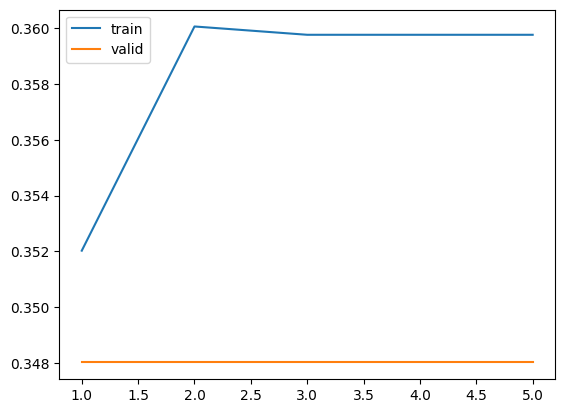

In [25]:
plot_train_metrics(history3)

### Evaluación

In [36]:
y_hat_prob_3 = model_3.predict(X_test_1)
y_hat_prob_3[:3]

99/99 [==============================] - 17s 176ms/step


array([[0.3159564 , 0.3236388 , 0.36040476],
       [0.3159564 , 0.3236388 , 0.36040476],
       [0.3159564 , 0.3236388 , 0.36040476]], dtype=float32)

In [37]:
y_hat_3 = np.argmax(y_hat_prob_3, axis=1)

In [38]:
# Calcular la exactitud (accuracy)
scores_3 = model_3.evaluate(X_test_1, y_test_1)
scores_3[1]

99/99 [==============================] - 18s 180ms/step - loss: 1.0956 - accuracy: 0.3727 - f1_score: 0.1810


0.37269842624664307

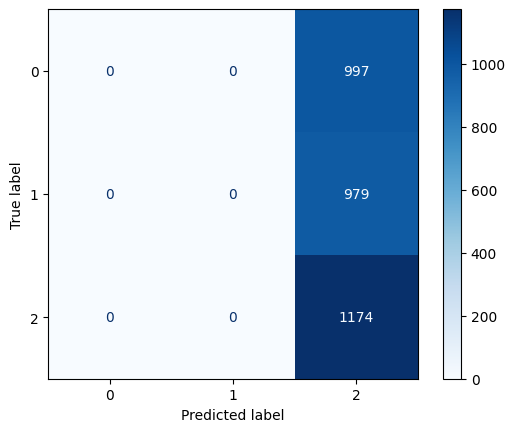

In [39]:
cm_3 = confusion_matrix(y_test_1.argmax(axis=1), y_hat_3)
cmd_3 = ConfusionMatrixDisplay(cm_3, display_labels=list(range(3)))
cmd_3.plot(cmap=plt.cm.Blues)
plt.show()

### Comentarios

Se observa que el clasificador tan solo etiqueta todos los casos como clase 2, resultando en un mero caso trivial. 

## Modelo #4

### Definición

Este modelo toma la mejor arquitectura evaluada hasta el momento. Intentará resolver el problema con las clases de salida originales, que como ya se ha visto en el EDA, se encuentran desbalanceadas.

In [21]:
output_shape = 5

In [22]:
bert_model.bert.trainable = True

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_4 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_4.compile(optimizer=tensorflow.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

In [23]:
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

### Feature Engineering

Se convierten los targets a variables **OHE**.

In [28]:
y_2 = df['score'].values
print("y shape:", y_2.shape)
y_2 = to_categorical(y_2)
y_2 = y_2[:, 1:]  # Se elimina la primera columna con valores "0"
print(y_2[:3])
output_shape = y_2.shape[1]
print("output shape:", output_shape)

y shape: (15746,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
output shape: 5


In [29]:
train_InputExamples_2, validation_InputExamples_2 = convert_data_to_examples(sentences, y_2, idx_train, idx_val)

train_data_2 = convert_examples_to_tf_dataset(list(train_InputExamples_2), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data_2 = train_data_2.shuffle(100).batch(32)

validation_data_2 = convert_examples_to_tf_dataset(list(validation_InputExamples_2), bert_tokenizer, max_length=max_length)
validation_data_2 = validation_data_2.batch(32)

In [30]:
pred_sentences_2 = [sentences[i] for i in idx_test]
tf_batch_2 = bert_tokenizer(pred_sentences_2, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [31]:
X_test_2 = [tf_batch_2['input_ids'],  
          tf_batch_2['attention_mask']]

In [32]:
y_test_2 = y_2[idx_test]

### Entrenamiento

In [33]:
history4 = model_4.fit(train_data_2, epochs=5, validation_data=validation_data_2)

Epoch 1/5


I0000 00:00:1723957377.588363      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - 379s 948ms/step - loss: 1.2989 - accuracy: 0.4352 - f1_score: 0.3869 - val_loss: 1.1049 - val_accuracy: 0.5282 - val_f1_score: 0.4578
Epoch 2/5
315/315 [==============================] - 287s 911ms/step - loss: 1.0272 - accuracy: 0.5594 - f1_score: 0.5273 - val_loss: 1.0281 - val_accuracy: 0.5786 - val_f1_score: 0.5403
Epoch 3/5
315/315 [==============================] - 287s 910ms/step - loss: 0.8671 - accuracy: 0.6452 - f1_score: 0.6264 - val_loss: 0.9963 - val_accuracy: 0.6087 - val_f1_score: 0.5914
Epoch 4/5
315/315 [==============================] - 287s 910ms/step - loss: 0.6946 - accuracy: 0.7208 - f1_score: 0.7081 - val_loss: 1.0262 - val_accuracy: 0.6476 - val_f1_score: 0.6352
Epoch 5/5
315/315 [==============================] - 287s 910ms/step - loss: 0.5242 - accuracy: 0.8047 - f1_score: 0.7956 - val_loss: 1.0575 - val_accuracy: 0.6659 - val_f1_score: 0.6520


In [34]:
plot_train_metrics(history4)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

### Evaluación

In [35]:
y_hat_prob_4 = model_4.predict(X_test_2)
y_hat_prob_4[:3]

99/99 [==============================] - 41s 295ms/step


array([[0.10690375, 0.5694429 , 0.22415332, 0.09610628, 0.00339374],
       [0.43269658, 0.53974676, 0.02005692, 0.00632836, 0.00117146],
       [0.00198745, 0.01092111, 0.2982821 , 0.66121596, 0.02759344]],
      dtype=float32)

In [36]:
y_hat_4 = np.argmax(y_hat_prob_4, axis=1)

In [37]:
# Calcular la exactitud (accuracy)
scores_4 = model_4.evaluate(X_test_2, y_test_2)
scores_4[1]

99/99 [==============================] - 41s 295ms/step - loss: 1.0201 - accuracy: 0.6692 - f1_score: 0.6560


0.6692063212394714

In [41]:
cm_4 = confusion_matrix(y_test_2.argmax(axis=1), y_hat_4)
cmd_4 = ConfusionMatrixDisplay(cm_4, display_labels=list(range(5)))
cmd_4.plot(cmap=plt.cm.Blues)
plt.show()

### Comentarios

Considerando que en este caso se tienen mayor cantidad de clases de salida, y que además, estas se encuentran desbalanceadas, se podría decir que el desempeño es aceptable.

## Almacenaje y testeo del mejor modelo

A continuación se realizarán inferencias con el mejor modelo entrenado.

In [39]:
model_2.save_weights('bert_weights.h5')

In [28]:
output_shape = 3

In [9]:
input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model_test = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model_test.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.F1Score(average='macro')])

In [10]:
model_test.load_weights('bert_weights.h5')

In [38]:
text = "I'm not sure"

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[ 101 1045 1005 1049 2025 2469  102    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/home/nata/Documentos/Git/nlp/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
X_ensayo = [tf_batch['input_ids'],  
          tf_batch['attention_mask']]

In [40]:
y_prob_ensayo = model_test.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 281ms/step
Clasificación: neutral


### Conclusiones

Se obtienen muy buenos resultados con el mejor modelo entrenado, tal y como se ha comentado previamente en la etapa de evaluación.